In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython
import IPython.display
import os
import datetime
from pathlib import Path

> En este *notebook* se analiza la serie temporal. Luego se entrena un modelo LSTM *multi-step single-shot*, se evalúa su rendimiento y se guarda. Finalmente, se carga el modelo y se predicen las 24 horas siguientes.

### Importa el dataset

In [3]:
CAMERA_NAME = "TV08-MANUEL_ALCANTARA"
path = Path("/home/salva/PycharmProjects/traffic-analyzer-tfg/Data Forecasting") / "CSV" / str(CAMERA_NAME + ".csv")
df = pd.read_csv(path.as_posix())
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")

### Agrega los datos cada 5 minutos usando la mediana

In [4]:
df = df.resample("5T").median().ffill().astype(int)

### Visualiza el dataset

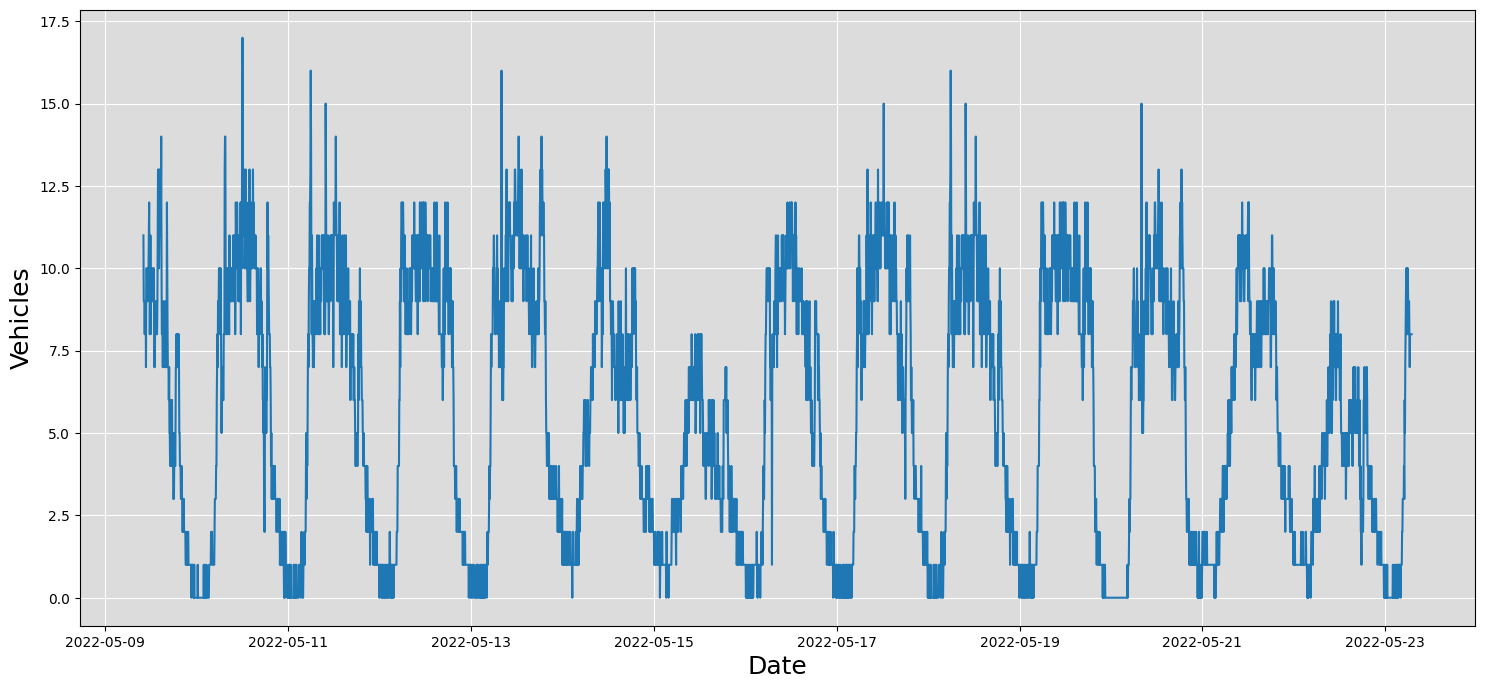

In [5]:
fig, axis = plt.subplots(facecolor="white", figsize=(18, 8))

axis.set_xlabel(xlabel="Date", fontsize=18)
axis.set_ylabel(ylabel="Vehicles", fontsize=18)    
axis.grid(color="white")
axis.set_facecolor("gainsboro")
axis.plot(df["n_vehicles"])
plt.savefig('resampled.svg', bbox_inches='tight')

### Describe algunos valores estadísticos

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_vehicles,3996.0,4.264264,3.280577,0.0,1.0,4.0,7.0,17.0


### Divide los datos en los conjuntos: `train`, `validation` y `test`

> Los datos no se mezclan a la hora de hacer la división. Se necesitan los datos de forma consecutiva.

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
 
train_df = df[0:int(n*0.7)] 
val_df = df[int(n*0.7):int(n*0.9)] 
test_df = df[int(n*0.9):]

num_features = df.shape[1]

> Es muy importante normalizar los datos. Esto se suele hacer siempre, no funciona si no. El orden es: normalizar, entrenar, pronosticar nuevos valores y desnormalizar los pronósticos.

In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Comprueba que la serie temporal es estacionaria

In [8]:
from statsmodels.tsa.stattools import adfuller


def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags','# of observations used']
    
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis.\nReject Null Hypothesis.\nData has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis.\nFail to reject Null Hypothesis.\nData has a unit root and is non-stationary.")

adf_check(df['n_vehicles'][:10000])

Augmented Dicky-Fuller Test
ADF Test Statistic : -5.8005716442530195
p-value : 4.641450993879502e-07
# of lags : 14
# of observations used : 3981
Strong evidence against null hypothesis.
Reject Null Hypothesis.
Data has no unit root and is stationary.


### Crea la clase Data Window

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


### Crea la función para partir los datos de las ventanas

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### Visualiza las ventanas de tiempo

In [11]:
def plot(self, model=None, plot_col="n_vehicles", max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

### Crea un dataset de `TensorFlow`

In [12]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Configura los argumentos para la ventana de tiempo

Predice las 24 horas siguientes dada la semana anterior.

In [13]:
OUT_STEPS = 288 # (24*60)/5 = 288 puntos para representar 24 horas en grupos de 5 minutos
window_size = 2016 # uso la semana anterior. 288*7
multi_window = WindowGenerator(input_width=window_size,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

#multi_window.plot()
multi_window

Total window size: 2304
Input indices: [   0    1    2 ... 2013 2014 2015]
Label indices: [2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029
 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043
 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057
 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071
 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085
 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099
 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111 2112 2113
 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125 2126 2127
 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139 2140 2141
 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153 2154 2155
 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167 2168 2169
 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181 2182 2183
 2184 2185 2186 2187 2188 2189 2190 2191 2192 2193 2194 21

### Entrena un modelo LSTM *multi-step* directo

In [14]:
multi_val_performance = {}
multi_performance = {}

MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [15]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/100


2022-10-07 16:02:36.391455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-07 16:02:36.391475: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-07 16:02:36.391491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Desarrollo14): /proc/driver/nvidia/version does not exist
2022-10-07 16:02:36.391760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16/16 [==============================] - 8s 382ms/step - loss: 0.9874 - mean_absolute_error: 0.8750
Epoch 2/100
16/16 [==============================] - 6s 369ms/step - loss: 0.8540 - mean_absolute_error: 0.8053
Epoch 3/100
16/16 [==============================] - 6s 372ms/step - loss: 0.7086 - mean_absolute_error: 0.7114
Epoch 4/100
16/16 [==============================] - 6s 377ms/step - loss: 0.6586 - mean_absolute_error: 0.6676
Epoch 5/100
16/16 [==============================] - 6s 371ms/step - loss: 0.6413 - mean_absolute_error: 0.6488
Epoch 6/100
16/16 [==============================] - 6s 374ms/step - loss: 0.6239 - mean_absolute_error: 0.6387
Epoch 7/100
16/16 [==============================] - 6s 379ms/step - loss: 0.6083 - mean_absolute_error: 0.6311
Epoch 8/100
16/16 [==============================] - 6s 372ms/step - loss: 0.5843 - mean_absolute_error: 0.6187
Epoch 9/100
16/16 [==============================] - 6s 375ms/step - loss: 0.5384 - mean_absolute_error: 0.5913
Epoc

Epoch 25/100
16/16 [==============================] - 6s 378ms/step - loss: 0.2013 - mean_absolute_error: 0.3358
Epoch 26/100
16/16 [==============================] - 6s 370ms/step - loss: 0.1974 - mean_absolute_error: 0.3325
Epoch 27/100
16/16 [==============================] - 6s 378ms/step - loss: 0.1939 - mean_absolute_error: 0.3291
Epoch 28/100
16/16 [==============================] - 6s 376ms/step - loss: 0.1917 - mean_absolute_error: 0.3271
Epoch 29/100
16/16 [==============================] - 6s 382ms/step - loss: 0.1890 - mean_absolute_error: 0.3247
Epoch 30/100
16/16 [==============================] - 6s 379ms/step - loss: 0.1862 - mean_absolute_error: 0.3220
Epoch 31/100
16/16 [==============================] - 6s 380ms/step - loss: 0.1841 - mean_absolute_error: 0.3200
Epoch 32/100
16/16 [==============================] - 6s 380ms/step - loss: 0.1816 - mean_absolute_error: 0.3173
Epoch 33/100
16/16 [==============================] - 6s 376ms/step - loss: 0.1788 - mean_absolu

Epoch 49/100
16/16 [==============================] - 6s 375ms/step - loss: 0.1500 - mean_absolute_error: 0.2837
Epoch 50/100
16/16 [==============================] - 6s 378ms/step - loss: 0.1503 - mean_absolute_error: 0.2839
Epoch 51/100
16/16 [==============================] - 6s 381ms/step - loss: 0.1496 - mean_absolute_error: 0.2832
Epoch 52/100
16/16 [==============================] - 6s 387ms/step - loss: 0.1471 - mean_absolute_error: 0.2810
Epoch 53/100
16/16 [==============================] - 6s 375ms/step - loss: 0.1456 - mean_absolute_error: 0.2793
Epoch 54/100
16/16 [==============================] - 6s 378ms/step - loss: 0.1446 - mean_absolute_error: 0.2783
Epoch 55/100
16/16 [==============================] - 6s 377ms/step - loss: 0.1436 - mean_absolute_error: 0.2774
Epoch 56/100
16/16 [==============================] - 6s 375ms/step - loss: 0.1426 - mean_absolute_error: 0.2764
Epoch 57/100
16/16 [==============================] - 6s 381ms/step - loss: 0.1418 - mean_absolu

Epoch 73/100
16/16 [==============================] - 6s 378ms/step - loss: 0.1325 - mean_absolute_error: 0.2654
Epoch 74/100
16/16 [==============================] - 6s 374ms/step - loss: 0.1316 - mean_absolute_error: 0.2644
Epoch 75/100
16/16 [==============================] - 6s 377ms/step - loss: 0.1321 - mean_absolute_error: 0.2647
Epoch 76/100
16/16 [==============================] - 6s 374ms/step - loss: 0.1314 - mean_absolute_error: 0.2641
Epoch 77/100
16/16 [==============================] - 6s 378ms/step - loss: 0.1303 - mean_absolute_error: 0.2628
Epoch 78/100
16/16 [==============================] - 6s 376ms/step - loss: 0.1313 - mean_absolute_error: 0.2638
Epoch 79/100
16/16 [==============================] - 6s 376ms/step - loss: 0.1294 - mean_absolute_error: 0.2619
Epoch 80/100
16/16 [==============================] - 6s 382ms/step - loss: 0.1289 - mean_absolute_error: 0.2611
Epoch 81/100
16/16 [==============================] - 6s 381ms/step - loss: 0.1286 - mean_absolu

Epoch 97/100
16/16 [==============================] - 6s 381ms/step - loss: 0.1244 - mean_absolute_error: 0.2555
Epoch 98/100
16/16 [==============================] - 6s 385ms/step - loss: 0.1243 - mean_absolute_error: 0.2554
Epoch 99/100
16/16 [==============================] - 6s 376ms/step - loss: 0.1242 - mean_absolute_error: 0.2551
Epoch 100/100
16/16 [==============================] - 6s 379ms/step - loss: 0.1235 - mean_absolute_error: 0.2543


### Guarda el modelo

In [16]:
# https://www.tensorflow.org/tutorials/keras/save_and_load
path = Path("/home/salva/PycharmProjects/traffic-analyzer-tfg/Data Forecasting") / "models" / str(CAMERA_NAME + "_LSTM")
multi_lstm_model.save(path.as_posix())

INFO:tensorflow:Assets written to: /home/salva/PycharmProjects/traffic-analyzer-tfg/Data Forecasting/models/TV06-PSO._PARQUE_LSTM/assets


INFO:tensorflow:Assets written to: /home/salva/PycharmProjects/traffic-analyzer-tfg/Data Forecasting/models/TV06-PSO._PARQUE_LSTM/assets


### Evalúa el modelo

> A la hora de evaluar el modelo es importante tener en cuenta que se tengan suficientes datos. Si el tamaño de ventana definido es demasiado grande como para la cantidad de datos que tenemos, la evaluación no se podrá llevar a cabo. Por ejemplo, si intentamos usar el 95% de nuestros datos para el entrenamiento y el 10% para la validar, las cuentas no salen porque faltan datos para probar con el resto. 

In [17]:
# https://stackoverflow.com/questions/64200512/tensorflow-evalutaion-and-earlystopping-gives-infinity-overflow-error
IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
# multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(multi_lstm_model)

### Pronostica puntos desconocidos

> Normaliza con la media y la desviación típica de los datos de entrenamiento antes de llamar a `predict()`. El modelo ha sido entrenado con los datos normalizados.

In [18]:
x = df["n_vehicles"][-window_size:].values # obtengo los últimos valores de  la serie 
x_norm = (x - train_mean.values) / train_std.values # normalizo
x_norm = np.expand_dims(x_norm,axis=0) # el modelo espera un input con ese shape
pred_norm = multi_lstm_model.predict(x_norm)[0] # llamo a predict()

1/1 [==============================] - 0s 362ms/step


> Desnormaliza los resultados pronosticados. Si para normalizar se hizo `(x - mean) / std`, para despejar x, es `x * std + mean`. 

In [19]:
# https://stackoverflow.com/questions/37595891/how-to-recover-original-values-after-a-model-predict-in-keras
pred = pred_norm * train_std.values + train_mean.values
pred = [int(p) for p in pred]

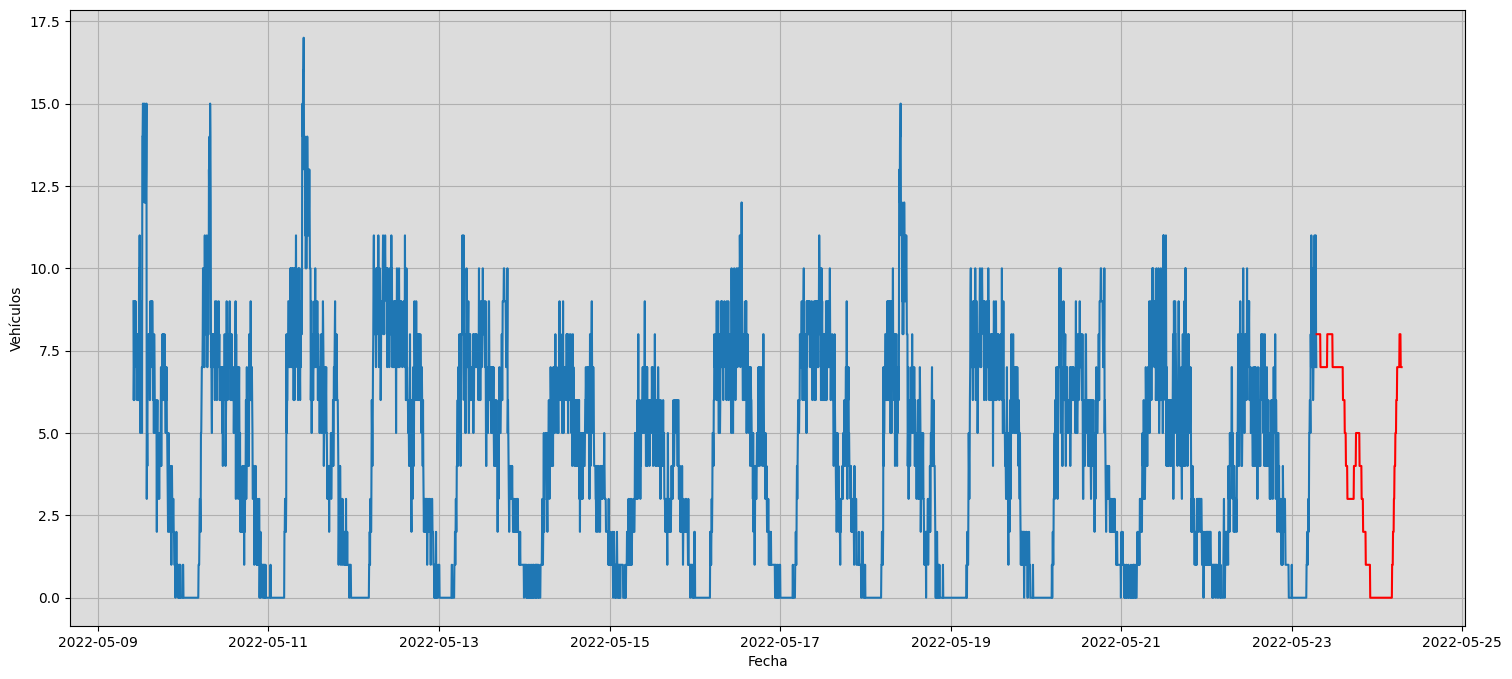

In [20]:
fig, axis = plt.subplots(facecolor="white", figsize=(18, 8))
axis.grid()
axis.set_xlabel(xlabel="Fecha")
axis.set_ylabel(ylabel="Vehículos")
axis.set_facecolor("gainsboro")
last_date = df.index.max()
freq = "5T"
horizon = len(pred)
new_dates = pd.date_range(start=last_date, periods=horizon + 1, freq=freq, inclusive="right")
axis.plot(df, label="observación")
axis.plot(new_dates, pred, color="red", label="predicción")

### Carga el modelo

In [9]:
path = Path("/home/salva/PycharmProjects/traffic-analyzer-tfg/Data Forecasting") / "models" / str(CAMERA_NAME + "_LSTM")
loaded_multi_lstm = tf.keras.models.load_model(path.as_posix())

1/1 [==============================] - 0s 65ms/step


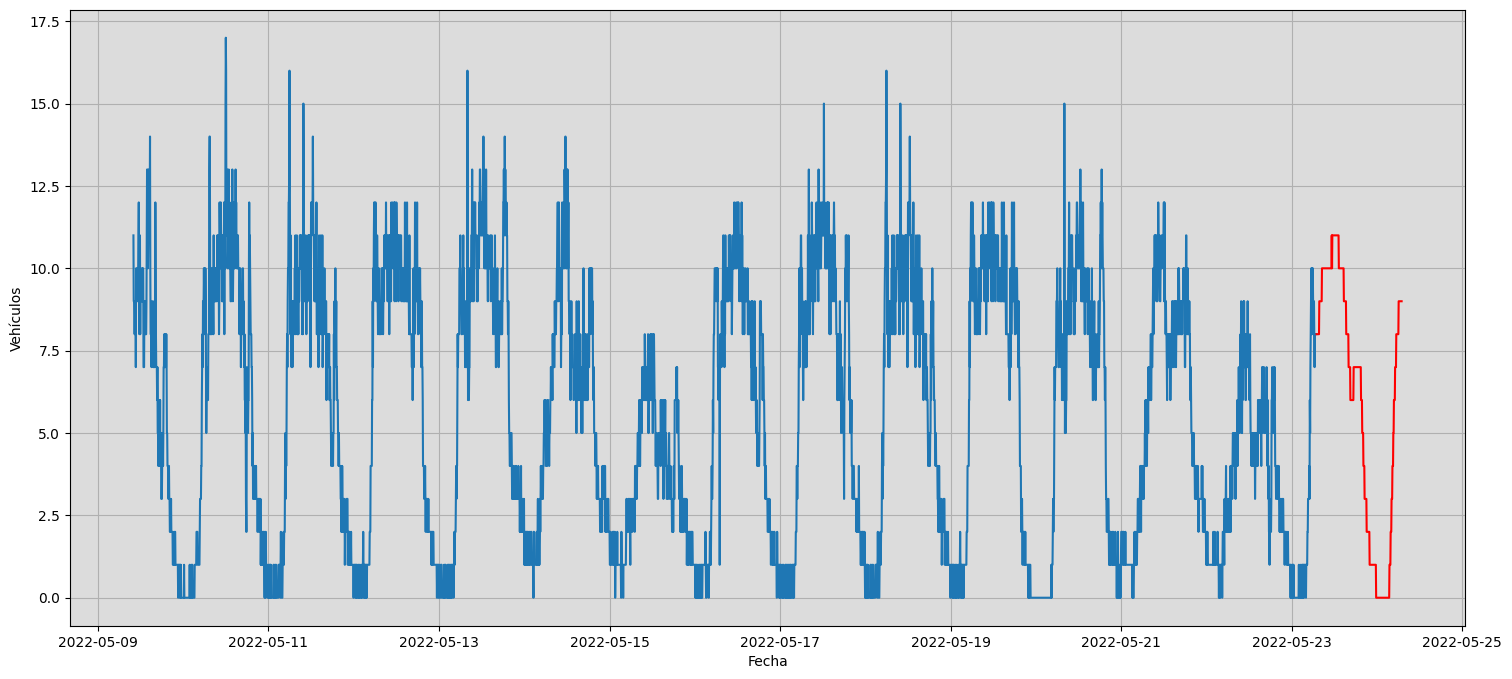

In [13]:
x = df["n_vehicles"][-2016:].values # obtengo los últimos valores de  la serie 
x_norm = (x - train_mean.values) / train_std.values # normalizo
x_norm = np.expand_dims(x_norm,axis=0) # el modelo espera un input con ese shape
pred_norm = loaded_multi_lstm.predict(x_norm)[0] # llamo a predict()
pred = pred_norm * train_std.values + train_mean.values
pred = [int(p) for p in pred]
fig, axis = plt.subplots(facecolor="white", figsize=(18, 8))
axis.grid()
axis.set_xlabel(xlabel="Fecha")
axis.set_ylabel(ylabel="Vehículos")
axis.set_facecolor("gainsboro")
last_date = df.index.max()
freq = "5T"
horizon = len(pred)
new_dates = pd.date_range(start=last_date, periods=horizon + 1, freq=freq, inclusive="right")
axis.plot(df, label="observación")
axis.plot(new_dates, pred, color="red", label="predicción")
plt.savefig('fore.svg', bbox_inches='tight')